# Bigram Language Modeling using a basic Neural Network for generating Onion-like News Headlines

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Data Setup

In [3]:
try:
  onion_df = pd.read_csv('../data/cleaned_onion_headlines.csv')
except FileNotFoundError:
  onion_df = pd.read_csv('../data/original_onion_headlines.csv')
  onion_df['text'] = onion_df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
  onion_df['text'] = onion_df['text'].apply(str.lower)
  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub('[$=`+@*#_]', '', t))
  onion_df.to_csv('../data/cleaned_onion_headlines.csv', index=None)

onion_df.shape

(14363, 1)

In [4]:
onion_df['length'] = onion_df['text'].apply(len)
onion_df['length'].describe()

count    14363.000000
mean        77.819745
std         30.673678
min          1.000000
25%         56.500000
50%         75.000000
75%         94.000000
max        283.000000
Name: length, dtype: float64

## Bigram Language Model

In [5]:
texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
len(vocab)

55

In [9]:
xs,ys = [],[]
for text in texts[:1]:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(idx1)
    ys.append(idx2)

xs,ys = torch.tensor(xs),torch.tensor(ys)

# e
e n
n t
t i
i r
r e
e  
  f
f a
a c
c e
e b
b o
o o
o k
k  
  s
s t
t a
a f
f f
f  
  l
l a
a u
u g
g h
h s
s  
  a
a s
s  
  m
m a
a n
n  
  t
t i
i g
g h
h t
t e
e n
n s
s  
  p
p r
r i
i v
v a
a c
c y
y  
  s
s e
e t
t t
t i
i n
n g
g s
s #


In [12]:
xs

tensor([ 0, 32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46,
        47, 28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,
         1, 47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1,
        46, 32, 47, 47, 36, 41, 34, 46])

In [13]:
ys

tensor([32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46, 47,
        28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,  1,
        47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1, 46,
        32, 47, 47, 36, 41, 34, 46,  0])

Make sure to cast the encoding to `float` because we don't want to pass `int` into the neural network

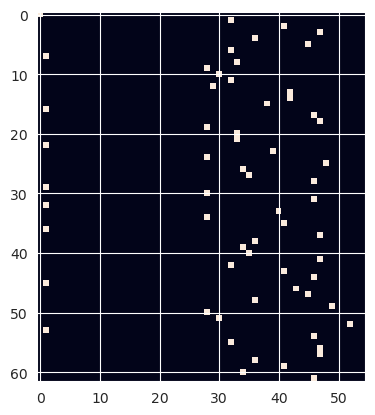

In [29]:
xenc = F.one_hot(xs, num_classes=55).float()
plt.imshow(xenc)

In [ ]:
bigram_counts[0]

In [ ]:
p = bigram_counts[0].float()/bigram_counts[0].sum()
p

In [ ]:
bigram_probs = bigram_counts.float()/bigram_counts.sum(axis=1, keepdim=True)

In [ ]:
bigram_probs[0] == p

In [ ]:
g = torch.Generator().manual_seed(2468975301)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

In [ ]:
g = torch.Generator().manual_seed(2468975301)
n_headlines = 20
for _ in range(n_headlines):
  idx = 0
  ai_onion = []
  while True:
    idx = torch.multinomial(bigram_probs[idx], num_samples=1, replacement=True, generator=g).item()
    ai_onion.append(itos[idx])
    if idx == 0:
      break
  print(''.join(ai_onion[:-1]))    

GOAL: Maximize the liklihood of the data w.r.t model parameters (statistical modeling). This is equivalent to:
1. maximizing the log liklihood (because log is monotonic)
2. minimizing the negative log liklihood
3. minimizing the average negative logliklihood

In [ ]:
cnn_headline = 'Trump goes to Supreme Court over Mar-a-Lago search and seizure of documents.'.lower()
onion_headline = 'High Schoolers Given Detention For Cutting Class During Active Shooting.'.lower()

In [ ]:
log_likelihood = 0.
n = 0
for text in texts:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    prob = bigram_probs[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{ch1}{ch2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {-log_likelihood/n:0.4f}")